# Projet : Reflector imaging from ambient noise signals

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
def simulated_sampling(N = 200):
    ys = np.vstack((np.random.uniform(-50,50, N),np.random.uniform(-10,10, N),np.random.uniform(185,200, N)))
    return ys.T

def receivers_sampling(n = 5):
    x = np.zeros((n,3))
    x[:,0] = np.arange(n)* 7.5 - 30
    x[:,2] = 100 * np.ones(n)
    return x

### 2) Preliminaries 

In [3]:
c0 = 1 
xr = -5 
yr = 0
zr = np.array([-5,0,65])
sigmar = 1e-3

In [4]:
y = simulated_sampling()
x = receivers_sampling()

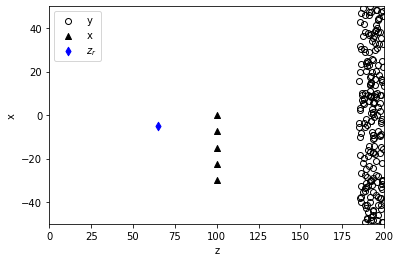

In [5]:
plt.scatter(y[:,2], y[:,0], marker='o', color=(1, 1, 1, 0), edgecolors='black', label='y')
plt.scatter(x[:,2], x[:,0], marker='^', color='black', label='x')
plt.scatter(zr[2], zr[0], marker='d', color='b', label=r'$z_r$')
plt.xlabel("z")
plt.xlim(0,200)
plt.ylim(-50,50)
plt.ylabel("x")
plt.legend()
plt.show()

In [10]:
def power_spectral_density(omega):
    return np.exp(-np.power(omega,2))*(omega > -5)

def homogeneous_green_function(omega,x,y):
    if len(x.shape)==1 and len(y.shape)==1 :
        z = np.linalg.norm(x-y)
    else : 
        z = np.linalg.norm(x-y, axis = 1)
    return 1/(4*np.pi*z)*np.exp(1j * omega/c0 * z)

def green_function(omega, x, y):
    G = homogeneous_green_function
    return G(omega,x,y) + sigmar * np.power(omega,2)*G(omega,x,zr)*G(omega,zr,y)


def empirical_cross_correlation(tau, x1, x2,y):    
    omega = np.linspace(-4, 4, 1000).reshape(-1,1)
    G_hat_G = np.conj(green_function(omega, x1, y)) * green_function(omega, x2, y)

    CN = np.dot(power_spectral_density(omega).T,G_hat_G.mean(1))*np.exp(-1j*omega*tau)
    return CN.sum(1)/(2*np.pi)

/Users/macrafa/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


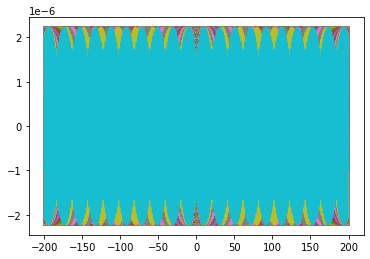

In [12]:
tau = np.linspace(-200,200,1000)

#f = empirical_cross_correlation(tau,x[4],x[0],y)
f = [empirical_cross_correlation(t,x[4],x[0],y) for t in tau]
plt.plot(tau, f)
plt.show()